Mounting at google drive

In [91]:
from google.colab import drive

drive.mount("/content/gdrive",force_remount=False)

Mounted at /content/gdrive


In [92]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


In [93]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
ratings = pd.read_csv('/content/drive/My Drive/ratings.csv')
len(ratings)

20000263

In [95]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

> # Checking if the user has rated the same movie twice, in that case we just take max of them


In [96]:
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

>  In this case there are no such cases where the user has rated the same movie twice.


In [97]:
len(ratings_df)

20000263

In [98]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [99]:
ratings_df.head()

rating   timestamp
userId movieId                    
1      2           3.5  1112486027
       29          3.5  1112484676
       32          3.5  1112484819
       47          3.5  1112484727
       50          3.5  1112484580

>  Counting no of unique users


In [100]:
len(ratings['userId'].unique())

138493

> Getting the percentage count of each rating value 


In [101]:
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [102]:
count_ratings

,userId,movieId,timestamp,perc_total
rating,,,,
0.5,239125,239125,239125,1.2
1.0,680732,680732,680732,3.4
1.5,279252,279252,279252,1.4
2.0,1430997,1430997,1430997,7.2
2.5,883398,883398,883398,4.4
3.0,4291193,4291193,4291193,21.5
3.5,2200156,2200156,2200156,11.0
4.0,5561926,5561926,5561926,27.8
4.5,1534824,1534824,1534824,7.7


> Visualising the percentage total for each rating

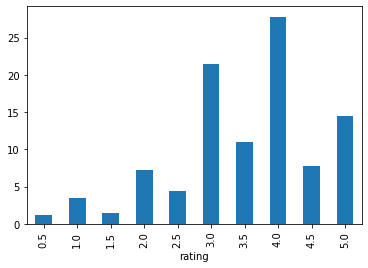

In [103]:
count_ratings['perc_total'].plot.bar()

> Reading the movies dataset

In [104]:
movie_list = pd.read_csv('/content/drive/My Drive/movies.csv')

In [105]:
len(movie_list)

27278

In [106]:
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


> Reading the tags dataset

In [107]:
tags = pd.read_csv('/content/drive/My Drive/tags.csv')

In [108]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [109]:
genres = movie_list['genres']

In [110]:
genres.head()


0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [111]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['Musical',
 'War',
 'Children',
 'Western',
 'Comedy',
 'Crime',
 'Animation',
 'Drama',
 'Action',
 'Sci-Fi',
 'Film-Noir',
 'Fantasy',
 'Adventure',
 'Thriller',
 'Horror',
 'Romance',
 'Mystery',
 '(no genres listed)',
 'Documentary',
 'IMAX']

> # Enriching the movies dataset by adding the various genres columns.


In [112]:
for genre in new_list :
    movie_list[genre] = movie_list.apply(lambda _:int(genre in _.genres), axis = 1)

In [113]:
movie_list.head()

,movieId,title,genres,Musical,War,Children,Western,Comedy,Crime,Animation,Drama,Action,Sci-Fi,Film-Noir,Fantasy,Adventure,Thriller,Horror,Romance,Mystery,(no genres listed),Documentary,IMAX
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
movie_list['movieId'] = movie_list['movieId'].astype(object)

In [115]:
movie_list.shape

(27278, 23)

> # Calculating the sparsity

In [116]:
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.995


>  Counting the number of unique movies in the dataset.

In [117]:
len(ratings['movieId'].unique())

26744

> Finding the average rating for movie and the number of ratings for each movie

In [118]:
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [119]:
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.921240,49695,1
2,3.211977,22243,2
3,3.151040,12735,3
4,2.861393,2756,4
5,3.064592,12161,5


In [120]:
len(avg_movie_rating)

26744

In [121]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=5
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.921240,49695,1
2,3.211977,22243,2
3,3.151040,12735,3
4,2.861393,2756,4
5,3.064592,12161,5


> # Creating a function for weighted rating score based on the count of reviews

In [122]:
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

> # Calculating the weighted score for each movie

In [123]:
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,mean,count,movieId,weighted_score
movieId,,,,
1,3.921240,49695,1,3.921200
2,3.211977,22243,2,3.212047
3,3.151040,12735,3,3.151187
4,2.861393,2756,4,2.862596
5,3.064592,12161,5,3.064781


In [124]:
movie_score = movie_score.drop(columns = 'movieId')

In [125]:
movie_score.reset_index()

,movieId,mean,count,weighted_score
0,1,3.921240,49695,3.921200
1,2,3.211977,22243,3.212047
2,3,3.151040,12735,3.151187
3,4,2.861393,2756,2.862596
4,5,3.064592,12161,3.064781
...,...,...,...,...
17514,129937,2.666667,12,2.919273
17515,130073,3.404762,21,3.427986
17516,130075,2.500000,17,2.733075
17517,130490,3.240000,25,3.287588


> # Joining the  movie details to the movie ratings

In [126]:
movie_score = pd.merge(movie_score,movie_list,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,Musical,War,Children,Western,Comedy,Crime,Animation,Drama,Action,Sci-Fi,Film-Noir,Fantasy,Adventure,Thriller,Horror,Romance,Mystery,(no genres listed),Documentary,IMAX
0,1,3.921240,49695,3.921200,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
1,2,3.211977,22243,3.212047,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,3,3.151040,12735,3.151187,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,2.861393,2756,2.862596,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,5,3.064592,12161,3.064781,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
movie_score = pd.merge(movie_score,tags,on='movieId')

In [128]:
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,Musical,War,Children,Western,Comedy,Crime,Animation,Drama,Action,Sci-Fi,Film-Noir,Fantasy,Adventure,Thriller,Horror,Romance,Mystery,(no genres listed),Documentary,IMAX,userId,tag,timestamp
0,1,3.92124,49695,3.9212,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1644,Watched,1417736680
1,1,3.92124,49695,3.9212,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1741,computer animation,1183903155
2,1,3.92124,49695,3.9212,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1741,Disney animated feature,1183933307
3,1,3.92124,49695,3.9212,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1741,Pixar animation,1183934770
4,1,3.92124,49695,3.9212,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1741,TÃ©a Leoni does not star in this movie,1245093573


In [129]:
movie_score.shape

(453837, 29)

> # This function will give the best movies according to genre based on weighted score which is calculated using **IMDB formula**


In [184]:
def best_movies_by_genre(genre,top_n):
    d = pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

In [185]:
#run function to return top recommended movies by genre
best_movies_by_genre('Comedy',10)

,title,count,mean,weighted_score
36333,Dr. Strangelove or: How I Learned to Stop Worr...,23220,4.247287,4.247131
181303,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",24349,4.197072,4.196934
451533,Zero Motivation (Efes beyahasei enosh) (2014),11,4.500000,4.195478
44324,"Thin Man, The (1934)",3358,4.184187,4.183208
52068,Wallace & Gromit: The Wrong Trousers (1993),15022,4.181068,4.180850
54734,"Princess Bride, The (1987)",32586,4.176732,4.176632
107564,Life Is Beautiful (La Vita è bella) (1997),18156,4.175837,4.175658
15234,Pulp Fiction (1994),67310,4.174231,4.174183
51797,Monty Python and the Holy Grail (1975),33024,4.174146,4.174048
64216,"Sting, The (1973)",14926,4.173556,4.173339


In [186]:
#run function to return top recommended movies by genre
best_movies_by_genre('Action',10)

,title,count,mean,weighted_score
97408,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180,4.273857
235434,Band of Brothers (2001),4305,4.263182,4.262327
203090,City of God (Cidade de Deus) (2002),12937,4.235410,4.235136
40574,North by Northwest (1959),15627,4.233538,4.233312
131589,Fight Club (1999),40106,4.227123,4.227036
336892,"Dark Knight, The (2008)",20438,4.220129,4.219959
55238,Raiders of the Lost Ark (Indiana Jones and the...,43295,4.219009,4.218929
134404,Yojimbo (1961),3559,4.211717,4.210754
12932,Star Wars: Episode IV - A New Hope (1977),54502,4.190672,4.190611
54019,Star Wars: Episode V - The Empire Strikes Back...,45313,4.188202,4.188129


In [187]:
#run function to return top recommended movies by genre
best_movies_by_genre('Drama',10)

,title,count,mean,weighted_score
18451,"Shawshank Redemption, The (1994)",63366,4.446990,4.446918
39024,"Godfather, The (1972)",41355,4.364732,4.364631
26620,Schindler's List (1993),50054,4.310175,4.310097
62159,"Godfather: Part II, The (1974)",27398,4.275641,4.275504
97666,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180,4.273857
235477,Band of Brothers (2001),4305,4.263182,4.262327
41136,Casablanca (1942),24349,4.258327,4.258176
42526,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935,4.256375
53767,One Flew Over the Cuckoo's Nest (1975),29932,4.248079,4.247958
202895,City of God (Cidade de Deus) (2002),12937,4.235410,4.235136


> Just including the tag "bollywood"

In [134]:
def best_movies_bollywood():
    d= pd.DataFrame(movie_score.loc[(movie_score["tag"]=="Bollywood")].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    d = d.drop_duplicates(keep = "first")
    e = pd.DataFrame(movie_score.loc[(movie_score["tag"]=="bollywood")].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    e = e.drop_duplicates(keep = "first")
    e.append(d)
    return e

In [135]:
best_movies_bollywood()

,title,count,mean,weighted_score,tag
34266,Song of the Little Road (Pather Panchali) (1955),761,4.139947,4.135937,bollywood
350202,Slumdog Millionaire (2008),9208,3.950478,3.950247,bollywood
381324,3 Idiots (2009),453,3.883002,3.879100,bollywood
290962,Water (2005),323,3.860681,3.855572,bollywood
186065,Monsoon Wedding (2001),2802,3.847787,3.847213,bollywood
324557,Paint It Yellow (Rang De Basanti) (2006),55,3.863636,3.835461,bollywood
446716,Yeh Jawaani Hai Deewani (2013),8,4.000000,3.817511,bollywood
278819,Sholay (1975),52,3.788462,3.765397,bollywood
315693,"Namesake, The (2006)",491,3.734216,3.732112,bollywood
214170,Fire (1996),120,3.704167,3.697021,bollywood


# > Gives the best movies with BOLLYWOOD tag according to genre based on weighted score which is calculated using IMDB formula


In [136]:
def best_movies_by_genre(genre,top_n):
    d= pd.DataFrame(movie_score.loc[(movie_score[genre]==1) & ((movie_score["tag"]=="Bollywood") | (movie_score["tag"]=="bollywood"))].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

In [137]:
best_movies_by_genre('Drama',10)

,title,count,mean,weighted_score,tag
34266,Song of the Little Road (Pather Panchali) (1955),761,4.139947,4.135937,bollywood
350188,Slumdog Millionaire (2008),9208,3.950478,3.950247,bollywood
381324,3 Idiots (2009),453,3.883002,3.879100,bollywood
216433,Lagaan: Once Upon a Time in India (2001),676,3.859467,3.857016,Bollywood
290962,Water (2005),323,3.860681,3.855572,bollywood
324557,Paint It Yellow (Rang De Basanti) (2006),55,3.863636,3.835461,bollywood
446716,Yeh Jawaani Hai Deewani (2013),8,4.000000,3.817511,bollywood
315658,"Namesake, The (2006)",491,3.734216,3.732112,bollywood
214173,Fire (1996),120,3.704167,3.697021,bollywood
374987,Jab We Met (2007),57,3.657895,3.647220,bollywood


In [138]:
best_movies_by_genre('Romance',10)

,title,count,mean,weighted_score,tag
350123,Slumdog Millionaire (2008),9208,3.950478,3.950247,bollywood
381324,3 Idiots (2009),453,3.883002,3.879100,bollywood
216433,Lagaan: Once Upon a Time in India (2001),676,3.859467,3.857016,Bollywood
290962,Water (2005),323,3.860681,3.855572,bollywood
186031,Monsoon Wedding (2001),2802,3.847787,3.847213,bollywood
446716,Yeh Jawaani Hai Deewani (2013),8,4.000000,3.817511,bollywood
278819,Sholay (1975),52,3.788462,3.765397,bollywood
315640,"Namesake, The (2006)",491,3.734216,3.732112,bollywood
280006,Dilwale Dulhania Le Jayenge (1995),66,3.659091,3.649685,bollywood
374987,Jab We Met (2007),57,3.657895,3.647220,bollywood


In [139]:
best_movies_by_genre('Animation',10)

,title,count,mean,weighted_score,tag


In [140]:
best_movies_by_genre('Comedy',10)

,title,count,mean,weighted_score,tag
381324,3 Idiots (2009),453,3.883002,3.879100,bollywood
216431,Lagaan: Once Upon a Time in India (2001),676,3.859467,3.857016,Bollywood
186030,Monsoon Wedding (2001),2802,3.847787,3.847213,bollywood
324557,Paint It Yellow (Rang De Basanti) (2006),55,3.863636,3.835461,bollywood
446716,Yeh Jawaani Hai Deewani (2013),8,4.000000,3.817511,bollywood
278819,Sholay (1975),52,3.788462,3.765397,bollywood
280006,Dilwale Dulhania Le Jayenge (1995),66,3.659091,3.649685,bollywood
374987,Jab We Met (2007),57,3.657895,3.647220,bollywood
414655,Zindagi Na Milegi Dobara (2011),21,3.642857,3.620294,Bollywood
381359,Hum Tum (2004),18,3.611111,3.592506,bollywood


# > Gives the best movies with HOLLYWOOD tag according to genre based on weighted score which is calculated using IMDB formula

In [141]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    d= pd.DataFrame(movie_score.loc[(movie_score[genre]==1) & ((movie_score["tag"]=="Hollywood") | (movie_score["tag"]=="hollywood"))].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    d = d.drop_duplicates(keep = "first")[:top_n]
    return d

In [142]:
best_movies_by_genre('Drama',10)

,title,count,mean,weighted_score,tag
41206,Casablanca (1942),24349,4.258327,4.258176,Hollywood
42539,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935,4.256375,Hollywood
43496,All About Eve (1950),4826,4.204103,4.203400,Hollywood
391549,Inception (2010),14023,4.156172,4.155947,Hollywood
105739,"Player, The (1992)",7846,3.952715,3.952443,hollywood
105763,"Player, The (1992)",7846,3.952715,3.952443,Hollywood
430659,Argo (2012),2468,3.901742,3.900982,hollywood
430521,Argo (2012),2468,3.901742,3.900982,Hollywood
185807,"Bad and the Beautiful, The (1952)",261,3.877395,3.870781,Hollywood
293372,Thank You for Smoking (2006),7412,3.856382,3.856159,Hollywood


In [143]:
best_movies_by_genre('Action',10)

,title,count,mean,weighted_score,tag
55111,Raiders of the Lost Ark (Indiana Jones and the...,43295,4.219009,4.218929,Hollywood
391549,Inception (2010),14023,4.156172,4.155947,Hollywood
72608,Indiana Jones and the Last Crusade (1989),31280,4.007593,4.007516,Hollywood
374543,Zombieland (2009),5429,3.849880,3.849582,hollywood
161833,Beverly Hills Cop (1984),10516,3.556913,3.556898,Hollywood
345846,Tropic Thunder (2008),3320,3.416416,3.416580,Hollywood
102883,Blade (1998),11401,3.355627,3.355701,Hollywood
288435,King Kong (2005),5709,3.346733,3.346890,hollywood
437268,This Is the End (2013),639,3.326291,3.327838,Hollywood
227619,Paycheck (2003),2477,3.204078,3.204725,Hollywood


In [144]:
best_movies_by_genre('Children',10)

,title,count,mean,weighted_score,tag
206842,Holes (2003),2354,3.546092,3.546048,Hollywood


In [145]:
best_movies_by_genre('Romance',10)

,title,count,mean,weighted_score,tag
41206,Casablanca (1942),24349,4.258327,4.258176,Hollywood
42506,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935,4.256375,Hollywood
199155,Adaptation (2002),9383,3.845092,3.844922,Hollywood
416185,"Artist, The (2011)",1212,3.816832,3.815635,Hollywood
310028,"Holiday, The (2006)",1768,3.526301,3.526299,Hollywood
32821,Pretty Woman (1990),33900,3.420428,3.420443,Hollywood
287960,"Dying Gaul, The (2005)",55,3.063636,3.102127,Hollywood
172168,America's Sweethearts (2001),3841,2.851341,2.852217,Hollywood




# > Get top movie recommendations by a combination of genres







In [146]:
# Gives the best movies according to 2 genres based on weighted score which is calculated using IMDB formula
def best_movies_by_collective_genre(genre1,genre2,top_n):
    d = pd.DataFrame(movie_score.loc[(movie_score[genre1]==1) & (movie_score[genre2]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

In [147]:
best_movies_by_collective_genre("Fantasy", "Comedy" ,10)

,title,count,mean,weighted_score
54523,"Princess Bride, The (1987)",32586,4.176732,4.176632
51784,Monty Python and the Holy Grail (1975),33024,4.174146,4.174048
136409,Harvey (1950),3471,4.021608,4.020894
389728,Toy Story 3 (2010),5781,4.012974,4.012552
348186,FLCL (2000),679,4.006627,4.003111
129134,Time of the Gypsies (Dom za vesanje) (1989),345,4.005797,3.998936
71076,Young Frankenstein (1974),15087,3.996785,3.996629
426828,Presto (2008),168,3.982143,3.968946
244241,"Exterminating Angel, The (Ángel exterminador, ...",434,3.973502,3.968400
132974,Being John Malkovich (1999),27160,3.953203,3.953125


In [148]:
best_movies_by_collective_genre("Drama", "Action" ,10)

,title,count,mean,weighted_score
97581,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180,4.273857
235384,Band of Brothers (2001),4305,4.263182,4.262327
202802,City of God (Cidade de Deus) (2002),12937,4.235410,4.235136
130509,Fight Club (1999),40106,4.227123,4.227036
337200,"Dark Knight, The (2008)",20438,4.220129,4.219959
67164,"Treasure of the Sierra Madre, The (1948)",5155,4.161397,4.160781
392088,Inception (2010),14023,4.156172,4.155947
226642,"Lord of the Rings: The Return of the King, The...",31577,4.142382,4.142284
64082,"Boot, Das (Boat, The) (1981)",13612,4.139730,4.139504
68628,"Great Escape, The (1963)",10904,4.137656,4.137375


In [149]:
best_movies_by_collective_genre("Drama", "Animation" ,10)

,title,count,mean,weighted_score
201340,My Neighbor Totoro (Tonari no Totoro) (1988),5489,4.149481,4.148913
133450,Princess Mononoke (Mononoke-hime) (1997),9564,4.096299,4.096000
224746,Nausicaä of the Valley of the Wind (Kaze no ta...,3334,4.092082,4.091233
196389,Grave of the Fireflies (Hotaru no haka) (1988),3198,4.089744,4.088863
364972,Up (2009),9264,4.038266,4.037990
375369,Mary and Max (2009),1334,3.995127,3.993374
327016,Persepolis (2007),2249,3.971988,3.970997
259862,Whisper of the Heart (Mimi wo sumaseba) (1995),458,3.966157,3.961399
272582,"Man Who Planted Trees, The (Homme qui plantait...",196,3.971939,3.960834
258760,Kiki's Delivery Service (Majo no takkyûbin) (1...,2474,3.949879,3.949023


# Gives the best movies according to 3 genre based on weighted score which is calculated using IMDB formula


In [150]:
def best_movies_by_collective_genre(genre1,genre2,genre3,top_n):
    d = pd.DataFrame(movie_score.loc[(movie_score[genre1]==1) & (movie_score[genre2]==1) & (movie_score[genre3]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

In [151]:
best_movies_by_collective_genre("Drama", "Action", "Thriller" ,5)

,title,count,mean,weighted_score
202750,City of God (Cidade de Deus) (2002),12937,4.235410,4.235136
130426,Fight Club (1999),40106,4.227123,4.227036
391445,Inception (2010),14023,4.156172,4.155947
197001,"Professional, The (Le professionnel) (1981)",4495,4.101891,4.101251
236407,"Wages of Fear, The (Salaire de la peur, Le) (1...",712,4.082865,4.078979


In [152]:
best_movies_by_collective_genre("Drama", "Children" , "Romance" ,5)

,title,count,mean,weighted_score
381795,Anne of Green Gables: The Sequel (a.k.a. Anne ...,179,3.905028,3.894715
91538,Mulan (1998),7941,3.654578,3.654496
446723,Ernest & Célestine (Ernest et Célestine) (2012),39,3.576923,3.571083
388451,Donkey Skin (Peau d'âne) (1970),14,3.571429,3.559350
256181,"Wonderful World of the Brothers Grimm, The (1962)",13,3.500000,3.507091


In [153]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


> # Hollywood movies from a collection of 3 genres

In [154]:
def best_movies_by_collective_genre(genre1,genre2,genre3,top_n):
    d = pd.DataFrame(movie_score.loc[(movie_score[genre1]==1) & (movie_score[genre2]==1) & (movie_score[genre3]==1) & ((movie_score["tag"]=="Hollywood") | (movie_score["tag"]=="hollywood"))].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','tag']])
    d = d.drop_duplicates(keep = "first")
    return d[:top_n]

In [155]:
best_movies_by_collective_genre("Drama", "Action", "Thriller" ,5)

,title,count,mean,weighted_score,tag
391549,Inception (2010),14023,4.156172,4.155947,Hollywood
288378,King Kong (2005),5709,3.346733,3.346890,hollywood


In [156]:
del tags

# COLLABORATIVE FILTERING USING K MEANS CLUSTERING ALGORITHM

In [157]:
from sklearn.neighbors import NearestNeighbors


In [158]:
avg_movie_rating.head()


,mean,count,movieId
movieId,,,
1,3.921240,49695,1
2,3.211977,22243,2
3,3.151040,12735,3
4,2.861393,2756,4
5,3.064592,12161,5


> > # Only include movies with more than 10 ratings


In [159]:
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print(len(movie_plus_10_ratings))

15451


In [160]:
movie_plus_10_ratings

,mean,count,movieId
movieId,,,
1,3.921240,49695,1
2,3.211977,22243,2
3,3.151040,12735,3
4,2.861393,2756,4
5,3.064592,12161,5
...,...,...,...
129428,3.571429,21,129428
129937,2.666667,12,129937
130073,3.404762,21,130073


In [161]:
movie_plus_10_ratings = movie_plus_10_ratings.drop(columns='movieId')

In [162]:
movie_plus_10_ratings = movie_plus_10_ratings.reset_index()

In [163]:
movie_plus_10_ratings.head()

,movieId,mean,count
0,1,3.921240,49695
1,2,3.211977,22243
2,3,3.151040,12735
3,4,2.861393,2756
4,5,3.064592,12161


In [164]:
movie_plus_10_ratings.shape

(15451, 3)

In [165]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [166]:
ratings.shape

(20000263, 4)

In [167]:
filtered_ratings = pd.merge(movie_plus_10_ratings, ratings[:100000], on="movieId")

In [168]:
len(filtered_ratings)

99914

In [169]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,4.5,4.0,4.0,4.5,0.0,3.0,0.0,0.0,5.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,5.0,0.0,5.0,4.5,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,5.0,4.0,5.0,2.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,2.0,0.0,3.0,2.5,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,3.5,0.0,2.0,0.0,0.0,0.0


In [170]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [171]:
def print_similar_movies(query_index) :
    #get the list of user ratings for a specific userId
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movie_list.loc[movie_list['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movie_list.loc[movie_list['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [172]:
print_similar_movies(112552)

Recommendations for 23663    Whiplash (2014)
Name: title, dtype: object:

1: 24795    Theory of Everything, The (2014)
Name: title, dtype: object, with distance of 0.006116265326380876:
2: 21749    Nebraska (2013)
Name: title, dtype: object, with distance of 0.16562846965671496:
3: 24308    Fury (2014)
Name: title, dtype: object, with distance of 0.2191311905569696:
4: 18028    Tabloid (2010)
Name: title, dtype: object, with distance of 0.2191311905569696:
5: 6469    One, Two, Three (1961)
Name: title, dtype: object, with distance of 0.2191311905569696:
6: 24314    St. Vincent (2014)
Name: title, dtype: object, with distance of 0.2191311905569696:
7: 24539    Foxcatcher (2014)
Name: title, dtype: object, with distance of 0.2191311905569696:
8: 8408    Fury (1936)
Name: title, dtype: object, with distance of 0.2191311905569696:
9: 10859    Doogal (2006)
Name: title, dtype: object, with distance of 0.2191311905569696:
10: 24299    Judge, The (2014)
Name: title, dtype: object, with distan

In [174]:
print_similar_movies(1)

Recommendations for 0    Toy Story (1995)
Name: title, dtype: object:

1: 767    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object, with distance of 0.43716263833144964:
2: 3027    Toy Story 2 (1999)
Name: title, dtype: object, with distance of 0.46096151135937113:
3: 1184    Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object, with distance of 0.4697919813792829:
4: 640    Mission: Impossible (1996)
Name: title, dtype: object, with distance of 0.46998552209109634:
5: 476    Jurassic Park (1993)
Name: title, dtype: object, with distance of 0.47384052991806347:
6: 1052    Willy Wonka & the Chocolate Factory (1971)
Name: title, dtype: object, with distance of 0.48052315331878426:
7: 257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, with distance of 0.48359927108328493:
8: 352    Forrest Gump (1994)
Name: title, dtype: object, with distance of 0.4841645328848131:
9: 31    Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Name: titl

In [176]:
print_similar_movies(100)

Recommendations for 98    City Hall (1996)
Name: title, dtype: object:

1: 621    Primal Fear (1996)
Name: title, dtype: object, with distance of 0.626752368285407:
2: 1820    Henry Fool (1997)
Name: title, dtype: object, with distance of 0.6802244167642642:
3: 60    Eye for an Eye (1996)
Name: title, dtype: object, with distance of 0.6842098792996849:
4: 54    Georgia (1995)
Name: title, dtype: object, with distance of 0.7006795025712481:
5: 111    Before and After (1996)
Name: title, dtype: object, with distance of 0.7073566361451118:
6: 1466    Chef in Love, A (Shekvarebuli kulinaris ataser...
Name: title, dtype: object, with distance of 0.7074910303491477:
7: 1446    Quiet Room, The (1996)
Name: title, dtype: object, with distance of 0.7074910303491477:
8: 2404    Spanish Fly (1998)
Name: title, dtype: object, with distance of 0.7074910303491477:
9: 595    Wooden Man's Bride, The (Yan shen) (1994)
Name: title, dtype: object, with distance of 0.7074910303491477:
10: 1787    Friend o

> # Using only the title of the movie

In [177]:
tfidf = TfidfVectorizer(stop_words="english")
movie_list['title'] = movie_list['title'].fillna(" ")

In [178]:
overview_matrix = tfidf.fit_transform(movie_list['title'])

In [179]:
overview_matrix.shape

(27278, 21709)

Now, we have a ‘tfidf’ feature matrix for all the movies. Every movie has 21709 number of features (words ). Now, in order to find the similarity between the movies, we will use the cosine_similarity

In [180]:
similarity_matrix = linear_kernel(overview_matrix,overview_matrix)
mapping = pd.Series(movie_list.index,index = movie_list["title"])

In [181]:
def recommend_movies(movie_input):
    movie_index = mapping[movie_input]
    #get similarity values with other movies
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[movie_index]))
    #sort in descending order the similarity score of movie inputted with all the other movies
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 15 most similar movies. Ignore the first movie.
    similarity_score = similarity_score[1:15]
    #return movie names using the mapping series
    movie_indices = [i[0] for i in similarity_score]
    return (movie_list["title"].iloc[movie_indices])

In [182]:
recommend_movies("Animal Kingdom (2010)")

13243       Animal Kingdom, The (1932)
4245                Animal, The (2001)
25542                    Animal (1977)
12056              Kingdom, The (2007)
5805                 My Kingdom (2001)
3332               Animal House (1978)
26564               Animal Room (1995)
7850             Animal Factory (2000)
10060         Kingdom of Heaven (2005)
4155               Kingdom Come (2001)
23570            Broken Kingdom (2012)
10335               Animal Farm (1954)
12597    Forbidden Kingdom, The (2008)
27061        Kingdom of Shadows (2015)
Name: title, dtype: object